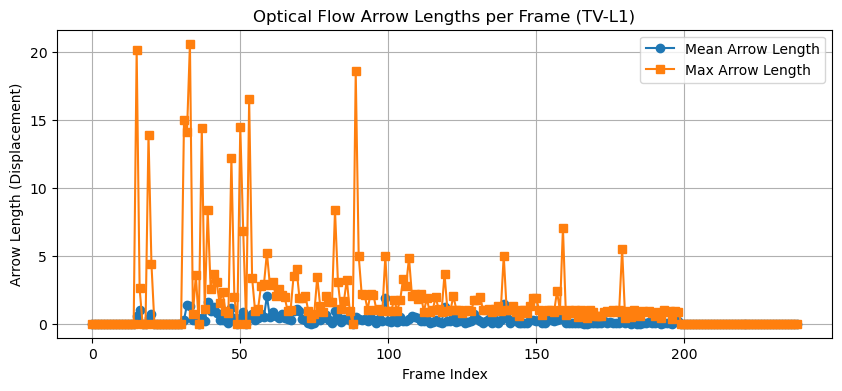

Frame Index  Mean Arrow Length  Max Arrow Length
0              0                0.0               0.0
1              1                0.0               0.0
2              2                0.0               0.0
3              3                0.0               0.0
4              4                0.0               0.0
..           ...                ...               ...
234          234                0.0               0.0
235          235                0.0               0.0
236          236                0.0               0.0
237          237                0.0               0.0
238          238                0.0               0.0

[239 rows x 3 columns]

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.color import rgb2gray
from skimage import io
from skimage import registration as skr
from skimage.exposure import rescale_intensity
import os

# 读取图像堆栈
astack = io.imread('masks.tif')

# 灰度处理 + 强度归一化
gray_stack = np.zeros((astack.shape[0], astack.shape[1], astack.shape[2]), dtype=np.float32)
for i in range(astack.shape[0]):
    gray = rgb2gray(astack[i]) if astack[i].ndim == 3 else astack[i]
    gray_stack[i] = rescale_intensity(gray, out_range=(0, 1))

# 配置画图参数
FIGSIZE = (8, 8)
nvec = 20
nr, nc = gray_stack.shape[1:]
step = max(nr // nvec, nc // nvec)
figdims = (int(plt.rcParams['figure.dpi'] * FIGSIZE[0]), int(plt.rcParams['figure.dpi'] * FIGSIZE[1]))
flow_stack = np.empty((gray_stack.shape[0]-1, figdims[1], figdims[0]))

# 初始化统计列表
mean_arrow_lengths = []
max_arrow_lengths = []

# 创建用于保存向量图像的文件夹
save_dir = 'flow_stack_images_tvl1'
os.makedirs(save_dir, exist_ok=True)

# 遍历帧对计算光流并绘图
for slice_index in range(gray_stack.shape[0]-1):
    flow = skr.optical_flow_tvl1(gray_stack[slice_index], gray_stack[slice_index+1])
    v, u = flow[0], flow[1]

    flow_magnitude = np.sqrt(u ** 2 + v ** 2)
    mean_arrow_lengths.append(np.mean(flow_magnitude))
    max_arrow_lengths.append(np.max(flow_magnitude))

    y, x = np.mgrid[:nr:step, :nc:step]
    u_ = u[::step, ::step]
    v_ = v[::step, ::step]

    fig = plt.figure(figsize=FIGSIZE, frameon=False, tight_layout=True)
    plt.imshow(gray_stack[slice_index], cmap='gray')
    plt.quiver(x, y, u_, v_, color='r', units='dots', angles='xy', scale=0.25, scale_units='xy', lw=3)
    plt.gca().set_axis_off()

    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    rgba = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    flow_stack[slice_index] = rgba[:, :, 1]

    fig.savefig(f"{save_dir}/slice_{slice_index:03d}.png", bbox_inches='tight', pad_inches=0)
    plt.close(fig)

# 绘制箭头长度趋势图
plt.figure(figsize=(10, 4))
plt.plot(mean_arrow_lengths, label='Mean Arrow Length', marker='o')
plt.plot(max_arrow_lengths, label='Max Arrow Length', marker='s')
plt.xlabel('Frame Index')
plt.ylabel('Arrow Length (Displacement)')
plt.title('Optical Flow Arrow Lengths per Frame (TV-L1)')
plt.legend()
plt.grid(True)
plt.show()

# 构建 DataFrame 表格展示
import pandas as pd
from IPython.display import display

arrow_df = pd.DataFrame({
    'Frame Index': list(range(len(mean_arrow_lengths))),
    'Mean Arrow Length': mean_arrow_lengths,
    'Max Arrow Length': max_arrow_lengths
})

display(arrow_df)

# 可选：保存为 CSV 文件
arrow_df.to_csv('arrow_lengths_tvl1.csv', index=False)
